<h1> <center> ENSF 519.01 Applied Data Scince </center></h1>
<h2> <center> Assignment 3: Supervised learning and dimension reduction (25 marks)</center></h2>
<h2> <center> Due: March 9, 2018. To be submitted on D2L Dropbox </center></h2>


In this assignment the focus is on ensemble models for learning and how preprocessing can help improving prediction scores. There are 5 parts that each may use different dataset. All datasets are available as csv files on D2L. 

<h2>Part A. Defect Prediction - Voting Ensemble Model (4 marks)</h2>
<br><br>
In this section you need to repeat what you did in your last assignment, HW2 at Part C, but this time you should use VotingClassifier function of SKlearn rather than the Combine function explained in that assignment.
<br>
Basically, you predict defects on the same NASA dataset using a simple ensemble model consisting of Logistic Regression, Gaussian Naive Bayes, and K-Nearest Neighbor estimators. You need to try both "soft voting" and "hard voting" options. 
<br>
All models and functions should be called by their default parameters.
<br>
Same as HW2, you calculate each combined score 30 times (with different random_state seeds for the train_test_splits).
Finally, visualize the results as three boxplots of 30 runs per: a) soft voting, b) hard voting, and c) your combined model’s results from HW2.

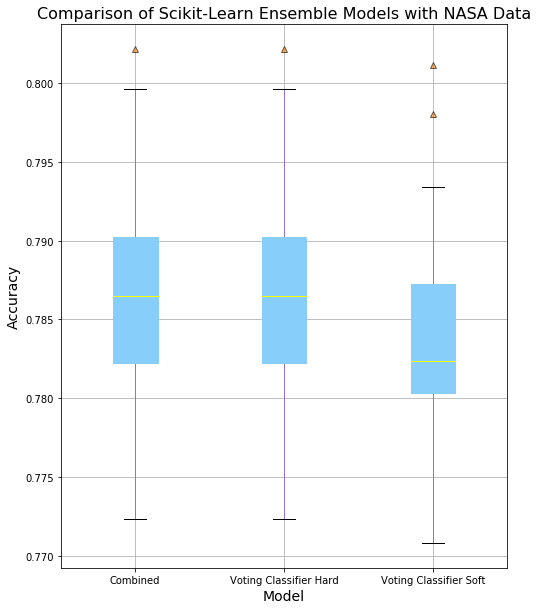

In [1]:
# pandas v0.22.0
import pandas as pd

# numpy v1.13.3
import numpy as np

# sklearn v0.19.1
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

# matplotlib v2.1.2
import matplotlib.pyplot as plt
%matplotlib inline

# load nasa file
nasa_path = "NasaData.csv"
try:
    nasa_df = pd.read_csv(nasa_path)
except FileNotFoundError as e:
    print(e)
    
# generate data sets
def split_data(df, count, col):
    for i in range(1, count + 1):
        yield train_test_split(df.drop(col, axis=1), df[col], test_size=0.25, random_state=i)
        
# simple ensemble models
def get_ensemble_scores(count, tuning):
    """
    Make `count` ensemble predictions and return the scores in a list.
    """
    scores = []
    vc = VotingClassifier(
        estimators = [
            ('lr', LogisticRegression()),
            ('gnb', GaussianNB()),
            ('knn', KNeighborsClassifier())
        ],
        **tuning
    )
    for X_train, X_test, y_train, y_test in split_data(nasa_df, 30, 'label'):
        # predict label: defective (1) or not defective (0)
        vc.fit(X_train, y_train)
        scores.append(vc.score(X_test, y_test))
    return scores

# combined model (assignment 2)
def combine(model_1, model_2, model_3, count):
    """
    Generates a weighted prediction from 3 models.
    -- Borrowed from Assignment 2 --
    """
    scores = []
    for seed in range(1, count + 1):
        vote_df = pd.DataFrame()
        for m in [model_1, model_2, model_3]:
            model = m()
            # take 75% of data as training set and 25% of as test set
            X_train, X_test, y_train, y_test = train_test_split(
                nasa_df.drop('label', axis=1), nasa_df['label'], test_size=0.25, random_state=seed)
            # train model
            model.fit(X_train, y_train)
            # predict class and probability
            preds = model.predict(X_test)
            probs = model.predict_proba(X_test)
            # calcuate weighted vote
            votes = []
            for i, p in enumerate(preds):
                if p == 1:
                    votes.append(probs[i][1])
                elif p == 0:
                    votes.append(-1 * probs[i][0])
                else:
                    raise RuntimeError("Invalid prediction class, ", p)
            vote_df[m.__name__ + '_v'] = votes

        # average the votes from each model and round to 0 or 1 for combined prediction
        y_pred = vote_df.mean(axis=1).apply(np.ceil).apply(np.absolute)
        
        # score prediction
        scores.append(accuracy_score(y_test, y_pred))
    return scores

# predict and score
run_count = 30
model_dist_df = pd.DataFrame({ "Voting Classifier Hard":get_ensemble_scores(run_count, {"voting":"hard"}),
                               "Voting Classifier Soft":get_ensemble_scores(run_count, {"voting":"soft"}),
                               "Combined":combine(LogisticRegression, GaussianNB, KNeighborsClassifier, run_count) })

# boxplots
ax = model_dist_df.plot.box(
    figsize=(8, 10),
    grid=True,
    patch_artist=True,
    flierprops={'markerfacecolor': '#ff7f00', 'marker': '^', 'alpha': 0.6},
    color=dict(boxes='lightskyblue', whiskers='mediumpurple', medians='yellow')
)
ax.set_title('Comparison of Scikit-Learn Ensemble Models with NASA Data')
ax.title.set_fontsize(16)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Model')
ax.yaxis.label.set_fontsize(14)
ax.xaxis.label.set_fontsize(14)

<h2>Part B. Linear Regression, Random Forest, and Gradient Boosting (5 marks) </h2>

In this section, our task is again defect prediction. However, this time each artifact may have zero, one, or more defects. Thus our job is not just predicting defective vs. non-defective targets, but we would like to predict the exact number of defects. This is useful since one can prioritize QA effort based on the number of defects as a sign of severity. To do so we treat the problem as a regression problem not a classification problem.

- <b> If we would use a classification rather than regression, explain what kind of classification problem this question could fit in and why? Explain why a regression solution is a better choice.



<b>Your Answer:</b> This would be called a "multi-class classification problem". Essentially, some discrete boundaries would need to be determined to set up a number of classes (since there are more than two possible values, it is not a "binary classification problem"). It is not practical to set up a class for _each_ value so if we used multi-class classification, we would probably be setting ranges (e.g. no bugs, more than 0 but less than 10 bugs, 11 to 100 bugs, etc.). Knowing the artifact has between 11 and 100 bugs isn't as helpful a predicted _continuous_ value such as 67 bugs. Since regression predicts quantities instead of discrete classes, it is a more suitable solution.

To build your models you should follow these steps: 
<br>
- read the data from "OO-DefectPrediction.csv" 

- apply a basic linear regression. (with all default parameters)

- apply random forest regression. (with all default parameters, that is e.g., n_estimators=10, etc.)

- apply gradient boosting regression. (with all default parameters, that is e.g., n_estimators=100, etc.)

- calculate all R^2s. Note: You should implement R^2s as follows: 
  - round each predicted value (y_pred) to create your rounded_y_pred (e.g., 1.6 --> 1 and 0.4 --> 0)
  - call sklearn.metrics.r2_score with (y_true, rounded_y_pred)


- Run each model 30 times, with a new train test split. Set random_state to range(1,30) every time you create a train-test set. Also use the same seed value ([1..30]) for the corresponding RandomForestRegressor and GradientBoostingRegressor's  random_state parameter. Keep the test set size as default. 

- Finally, print the median score of those 30 runs for the three models, on the test set.




In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score

# load file
defect_path = "OO-DefectPrediction.csv"
try:
    defect_df = pd.read_csv(defect_path)
except FileNotFoundError as e:
    print(e)

lr_scores = []
rfr_scores = []
gbr_scores = []
for i, (X_train, X_test, y_train, y_test) in enumerate(split_data(defect_df, 30, 'bug')):
    # predict bugs using defaults
    lr = LinearRegression().fit(X_train, y_train)
    rfr = RandomForestRegressor(random_state=i+1).fit(X_train, y_train)
    gbr = GradientBoostingRegressor(random_state=i+1).fit(X_train, y_train)

    lr_scores.append(r2_score(y_test, lr.predict(X_test).round()))
    rfr_scores.append(r2_score(y_test, rfr.predict(X_test).round()))
    gbr_scores.append(r2_score(y_test, gbr.predict(X_test).round()))

# calculate medians and display results
results = pd.Series([np.median(lr_scores), np.median(rfr_scores), np.median(gbr_scores)],
                    index=["Linear Regression", "Random Forest Regressor", "Gradient Boosting Regressor"])
display(results)

Linear Regression             -0.861343
Random Forest Regressor        0.162742
Gradient Boosting Regressor    0.181314
dtype: float64

<h2>Part C. Improving regression by tuning (5 marks)</h2>
<br><br>
In this part, we want to improve the R^2's achieved by the default setups, in Part B. To reduce the scope of the assignment we only focus on RandomForestRegressor, in this part. We approach the problem by tuning the RandomForestRegressor's main parameters (max_depth, and n_estimators).

You first need to apply RandomForestRegressor with different values of max_depth as [3,4,5,6,7,None] (None means no maximum). n_estimators should be tested with this values [10,20,30,...,100]. 

Keep other parameters of RandomForestRegressor the same as Part B. 

Run each configuration 30 times (with random seeds [1..30]) and calculate the median R^2 per configuration. 

Find the best configuration of n_estimators and max_depth among the ones you tested, with the highest median R^2. 

Report the best configuration you found by printing the max_depth, the n_estimators, and the resulting median R^2.

How much improvement you achieved compared to the default set up of RandomForestRegressor in Part B?


In [3]:
# fine tune RandomForestRegressor
rfr_fine_tuned_scores = []

# try various max_depth
for m in [3, 4, 5, 6, 7, None]:
    # try various n_estimators
    for n in range(10, 110, 10):
        # record a score for each of 30 seeds
        s = []
        for i, (X_train, X_test, y_train, y_test) in enumerate(split_data(defect_df, 30, 'bug')):
            rfr = RandomForestRegressor(random_state=i+1, max_depth=m, n_estimators=n).fit(X_train, y_train)
            s.append(r2_score(y_test, rfr.predict(X_test).round()))
        # store the median from all 30 runs
        rfr_fine_tuned_scores.append({"max_depth": m,
                                      "n_estimators": n,
                                      "r^2": np.median(s)})
# sort and print highest median
print("Highest Median R^2 and Configuration")
rfr_fine_tuned_df = pd.DataFrame(rfr_fine_tuned_scores)
top_result = rfr_fine_tuned_df.sort_values("r^2", ascending=False).head(1)
display(top_result)

# display difference
print("\nImprovement: {0} - {1} = {2}".format(top_result["r^2"].values[0],
                                              results["Random Forest Regressor"],
                                              top_result["r^2"].values[0] - results["Random Forest Regressor"]))

Highest Median R^2 and Configuration


,max_depth,n_estimators,r^2
27,5.0,80,0.336269



Improvement: 0.33626856846786435 - 0.16274237506034145 = 0.1735261934075229


<h1>Part D. Dimension reduction - feature selection (7 marks)</h1>
<br><br>

In this section, we want to compare the dimension reduction ability of PCA with linear regression models. 

To use linear regression model as a dimension reduction technique, we fit the model and pick the most informative features and represent the data with only those features. 

Our dataset is "ApacheAll.csv", which records some performance measurements of an APACHE Web Server, which have been collected using a standard benchmark. See https://zenodo.org/record/322483#.WoZap5PwaRv for more details about the dataset.

<br>
Steps:  
- Apply Linear Regression on "ApacheAll.csv" data and find the coefficient of each feature and pick the two greatest ones. Reduce the dimensionality of your dataset by only keeping these two features in your train and test set.
    - use default parameters.
- Fit a PCA model on the original training set and pick the first two principal components (which contains most of the variations). Transform both training and test sets to this new space (2 dimensions).
    - use default parameters.  
    
- Build 3 random forest regression models: a) use the train and test set given by linear regression selected features, b) use PCA transformed data, c) use the original training and test sets.
    
    
- repeat the above three steps 30 times with random_state range [1..30] for both train/test splitter and RandomForestRegressor. Note that for each run a new PCA and Linear regression should be applied (i.e., do not transform new data based on the old fitted models)

- For all three models 
    - print the median regression scores (over 30 runs) 

- Explain your observation with respect to relative performance of PCA and linear regression for dimension reduction and why this has happened.

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


#
# load file
#
apache_path = "ApacheAll.csv"
try:
    apache_loaded = pd.read_csv(apache_path)
except FileNotFoundError as e:
    print(e)

target = "$<Performance"
apache_X = apache_loaded.drop(target, axis=1)
apache_y = apache_loaded[target]
apache_df = dict()


#
# setup
#
models = ("original", "linear", "pca")
original, linear, pca = models
scores = dict()
for m in models:
    scores[m] = []


#
# outer loop
#
col_names_old = []
count = 30
for i in range(1, count+1):
   
    #
    # cache original data
    #
    (iX_train, iX_test, iy_train, iy_test) = range(4)
    apache_df[original] = train_test_split(apache_X, apache_y, test_size=0.25, random_state=i)


    #
    # calculate and cache linear regression data with reduced dimensionality
    #
    lr = LinearRegression().fit(apache_df[original][iX_train],
                                apache_df[original][iy_train])

    # find two highest coefficients
    coef_values = list(zip(apache_df[original][iX_train].columns, lr.coef_))
    coef_values.sort(key=lambda x: x[1], reverse=True)
    col_names = [x[0] for x in coef_values[:2]]
    
    # print top coefficients
    if (col_names_old != col_names):
        col_names_old = col_names
        print("Linear Regression Coefficients (top 5):\n")
        for col, coef in coef_values[:5]:
            print("{}: {}".format(col, coef))

    # cache data
    apache_df[linear] = (apache_df[original][iX_train][col_names],
                         apache_df[original][iX_test][col_names],
                         apache_df[original][iy_train],
                         apache_df[original][iy_test])


    #
    # calculate and cache PCA data transformed to top principle components
    #

    # Note: Typically, we would scale this data (e.g. to unit variance) before applying PCA.
    #       Since the instructions don't mention this, I'm assuming we don't in this assignment.
    # scaler = StandardScaler()
    # scaler.fit(apache_df[original][iX_train])
    # X_train_scaled = scaler.transform(apache_df[original][iX_train])
    # X_test_scaled = scaler.transform(apache_df[original][iX_test])

    p = PCA(n_components=2)
    p.fit(apache_df[original][iX_train])
    apache_df[pca] = (p.transform(apache_df[original][iX_train]),
                      p.transform(apache_df[original][iX_test]),
                      apache_df[original][iy_train],
                      apache_df[original][iy_test])
    

    #
    # make predictions with Random Forest Regressor for each model
    #
    rfr = dict()
    for m in models:
        rfr[m] = RandomForestRegressor(random_state=i).fit(apache_df[m][iX_train], apache_df[m][iy_train])
        s = r2_score(apache_df[m][iy_test], rfr[m].predict(apache_df[m][iX_test]))
        scores[m].append(s)

#
# print median R^2 scores
#
print("\n--\nMedian Regression Scores:\n")
for k,v in scores.items():
    print("{} median: {}".format(k, np.median(v)))
    

#
# print explanation
#
print(
"""
--
Explanation:

PCA takes 9 dimensions and compresses them down to 2. While this is helpful
for understanding the data (e.g. in a 2D scatter plot), it results in
information loss. If we change n_components to 9, the median score improves
significantly, from 0.19510 to 0.78921 (305% better)

The top two Linear Regression coefficients are much higher than the next
ones and so dropping other features doesn't affect the score as much. Adding
the other features back is equivalent to keeping the original data set,
0.67922 to 0.96205 (42% better)

In the end, we must remember that PCA is unsupervised whereas Linear Regression
is supervised. This gives it a distinct advantage in making predictions.
"""
)

Linear Regression Coefficients (top 5):

$KeepAlive: 676.6454910550486
$InMemory: 177.9812480660401
$FollowSymLinks: 22.832680684079314
$EnableSendfile: 21.188107078781904
$Base: 0.0

--
Median Regression Scores:

original median: 0.9620450307315443
linear median: 0.6792152860286267
pca median: 0.19510398980327753

--
Explanation:

PCA takes 9 dimensions and compresses them down to 2. While this is helpful
for understanding the data (e.g. in a 2D scatter plot), it results in
information loss. If we change n_components to 9, the median score improves
significantly, from 0.19510 to 0.78921 (305% better)

The top two Linear Regression coefficients are much higher than the next
ones and so dropping other features doesn't affect the score as much. Adding
the other features back is equivalent to keeping the original data set,
0.67922 to 0.96205 (42% better)

In the end, we must remember that PCA is unsupervised whereas Linear Regression
is supervised. This gives it a distinct advantage in ma

<h1>Part E. Dimension reduction for visualization (4 marks)</h1>

One of the main use cases of dimensionality reduction techniques is for visualization of high dimensional datasets.
In this part, we use the same OO-DefectPrediction.csv dataset and visualize it in just two dimensions.

Steps :

- Read the data from "OO-DefectPrediction.csv".
- Transform the data to principal components using pca. 
- visualize data using the two first principal components. You should use different color code to visualize number of bugs. 
- explain your observations.


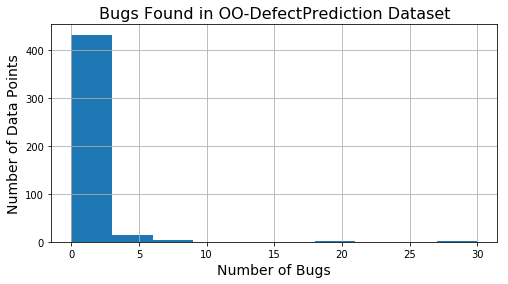

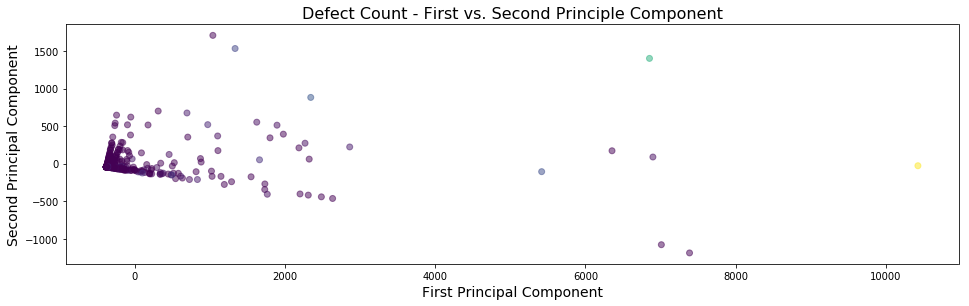


Based on the histogram and scatter plot, it's obvious that the purple colour represents
zero bugs. What's interesting is how the principle components converge in one area.

First PC: -500 to 500
Second PC: -100 to 400

This example shows how PCA plots are tricky to interpret (because they are comprised of
multiple dimensions which have been compressed). Nonetheless, another ML algorithm could
probably use this reduced dimensionality data to classify data points as having zero defects
if they fall in or near the purple cluster (described above).



In [5]:
# load the data
X = defect_df.drop('bug', axis=1)
y = defect_df['bug']

# transform the data to principal components using pca.
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

# create a data frame to manually inspect PCA values
fontsize=14
titlesize=16
_, ax = plt.subplots()
ax.set_title('Bugs Found in OO-DefectPrediction Dataset')
ax.title.set_fontsize(titlesize)
ax.set_ylabel('Number of Data Points')
ax.set_xlabel('Number of Bugs')
ax.yaxis.label.set_fontsize(fontsize)
ax.xaxis.label.set_fontsize(fontsize)
y.hist(figsize=(8, 4), ax=ax)

# visualize data using the two first principal components.
plt.figure(figsize=(16, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, alpha=0.5)
plt.gca().set_aspect("equal")
plt.title("Defect Count - First vs. Second Principle Component", fontsize=titlesize)
plt.xlabel("First Principal Component", fontsize=fontsize)
plt.ylabel("Second Principal Component", fontsize=fontsize)
plt.show()

# explain observations
print(
"""
Based on the histogram and scatter plot, it's obvious that the purple colour represents
zero bugs. What's interesting is how the principle components converge in one area.

First PC: -500 to 500
Second PC: -100 to 400

This example shows how PCA plots are tricky to interpret (because they are comprised of
multiple dimensions which have been compressed). Nonetheless, another ML algorithm could
probably use this reduced dimensionality data to classify data points as having zero defects
if they fall in or near the purple cluster (described above).
"""
)